# Retinal Eye Disease
---
## Introduction
There are many conditions that can negatively affect a person's vision, and the best way to prevent permanent vision loss from these conditions is early detection. There are some systemic conditions, like diabetes, where the damage to the eye is just one area of the body and the treatment for the eye can also help in other areas of a patient's health and well being.

The standard for screening retinal health has historically been dilation, this method is still used to this day but is being supported more and more with fundus photography. The images taken with one of these machines can provide a more detailed view of a patient's retina and the image is available to compare with future images to see any changes. The first photographs of the retina were taken in 1886, with the first commercially available fundus camerage produced in 1926 (source [National Library of Medicine](https://pmc.ncbi.nlm.nih.gov/articles/PMC4790203/)). These cameras have become more accessible, but are still not standard in all practices. The addition of newer handheld devices, while they don't provide as wide of a field of view as the larger version, can help provide access to this technology in more areas. 

In an attempt to build a tool to support analysis of these fundus images, I am working with a Kaggle [Ocular Disease](https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k) dataset that contains images for 5,000 patients with various conditions of the retina. With these images I will build a new Convolutional Neural Network (CNN) using Keras and compare to a transfer learning approach using ResNet152V2 and Xception models trained on the ImageNet dataset to address a binary classification problem: a normal and healthy retina vs. a non-healthy retina. The focus for all models will be on sensitivity in order to avoid missing a potentially damaging diagnosis in order to flag the image for further review. To consider a model ready for production I would want accuracy to be better than 90% and sensitivity to be better than 95%.

## Data Cleaning
The dataset hosted by Kaggle has the original images as well as these images preprocessed (resized to a uniform size and low quality images with no diagnosis removed). I will be utilizing these preprocessed images.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer

# setting plot style
plt.style.use('bmh')

In [2]:
# read in csv that classifies each image
images = pd.read_csv('../data/full_df.csv')

images.head()

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild nonproliferative retinopathy  0  1  0  0  0  0  0  1   
4  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
2  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
3  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
4  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   

                     target     filename  
0  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg  
1  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg  
2  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg  
3  [0, 1, 0, 0, 0, 0, 0, 0]  4_right.jpg  
4  [0, 1, 0, 0, 0, 0, 0, 0]  5_right.jpg

I need to update the filepaths to be able to access the images and sort them into a folder for each class. I will be working with the multiclass classification for all provided diseases as well as binary for normal labeled as 0 vs non-normal labeled as 1. The method I use below is modified from this [YouTube tutorial](https://www.youtube.com/watch?v=AtAVsFWxTkY).

All image data is stored in this [Google Drive](https://drive.google.com/drive/folders/1sbu1XlEluZJrbUmGFn5uPuOlhPmZ2QVV?usp=drive_link) where you can download to run the below code locally.

In [11]:
# updating filepath to the relative filepath
images['filepath'] = images['filepath'].apply(lambda x: x.replace('../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/', '../data/preprocessed_images/'))

In [12]:
# creating disease specific dataframes with the updated filepaths
normal = images[images['labels'] == "['N']"]
diabetes = images[images['labels'] == "['D']"]
glaucoma = images[images['labels'] == "['G']"]
cataract = images[images['labels'] == "['C']"]
amd = images[images['labels'] == "['A']"]
hypertension = images[images['labels'] == "['H']"]
myopia = images[images['labels'] == "['M']"]
other = images[images['labels'] == "['O']"]
not_normal = images[images['labels'] != "['N']"]

In [5]:
# function to create new directory
# method found on geeks for geeks
# https://www.geeksforgeeks.org/python-os-mkdir-method/
def make_dir(disease, model_class):
    # docstring for this function and others later in notebook written with the help of ChatGPT
    '''
    Create a directory for the specified disease class.

    This function takes the name of a disease class and binary or multiclass as input
    and creates a corresponding directly within the "../data/" parent directory.
    If a directory of the same name already exists, no action is taken.

    Parameters:
    ----------
    disease : str
        The name of the disease class to be used as the directory name
        
    model_class: {"binary", "multiclass"}
        Which classification problem the resulting directory will be sorted under

    Returns:
    -------
    None
    '''
    destination = disease
    parent_dir = '../data/'+model_class+'/'
    path = os.path.join(parent_dir, destination)

    # create the directory, pass if already exists
    try:
        os.mkdir(path)
    except FileExistsError:
        pass

In [6]:
disease_classes = {'normal': normal, 'diabetes': diabetes, 'glaucoma': glaucoma, 'cataract': cataract,
                   'amd': amd, 'hypertension': hypertension, 'myopia': myopia, 'other': other}

In [14]:
# making directory for each disease class
for disease in disease_classes.keys():
    make_dir(disease, 'multiclass')

# making two more directories for the binary classes
make_dir('0', 'binary')
make_dir('1', 'binary')

# copying images into respective multiclass disease class directory
for disease, disease_df in disease_classes.items():
    disease_df['filepath'].map(lambda x: shutil.copy(x, '../data/multiclass/'+disease))

# copying images into binary class directories
normal['filepath'].map(lambda x: shutil.copy(x, '../data/binary/0'))
not_normal['filepath'].map(lambda x: shutil.copy(x, '../data/binary/1'))

2         ../data/binary/1\2_right.jpg
3         ../data/binary/1\4_right.jpg
4         ../data/binary/1\5_right.jpg
5         ../data/binary/1\6_right.jpg
6         ../data/binary/1\7_right.jpg
                     ...              
6387    ../data/binary/1\4686_left.jpg
6388    ../data/binary/1\4688_left.jpg
6389    ../data/binary/1\4689_left.jpg
6390    ../data/binary/1\4690_left.jpg
6391    ../data/binary/1\4784_left.jpg
Name: filepath, Length: 3519, dtype: object

### Data Dictionary

All data is from Kaggle's [Ocular Disease Recognition Dataset](https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k).

|Feature|Type|Description|
|---|---|---|
|**ID**|*int*|Unique patient identifier|
|**Patient Age**|*int*|Age of patient|
|**Patient Sex**|*str*|Sex of patient|
|**Left-Fundus**|*str*|Filename for image of left eye for this patient|
|**Right-Fundus**|*str*|Filename for image of right eye for this patient|
|**Left-Diagnostic Keywords**|*str*|Diagnosis words for left eye fundus photo|
|**Right-Diagnostic Keywords**|*str*|Diagnosis words for right eye fundus photo|
|**N**|*int*|Normal fundus photo categorical column|
|**D**|*int*|Diabetes fundus photo categorical column|
|**G**|*int*|Glaucoma fundus photo categorical column|
|**C**|*int*|Cataract fundus photo categorical column|
|**A**|*int*|Age Related Macular Degeneration fundus photo categorical column|
|**H**|*int*|Hypertension fundus photo categorical column|
|**M**|*int*|Pathological Myopia fundus photo categorical column|
|**O**|*int*|Other diseases/abnormalities fundus photo categorical column|
|**filepath**|*str*|Filepath to the image for observation|
|**labels**|*str*|Diagnostic label for observation|
|**target**|*str*|Diagnostic target for observation|
|**filename**|*str*|Filename of image for observation|

## Exploratory Data Analysis

There are some elements of the data I want to investigate before looking at the images
* Diagnostic key words
* Distribution of patient demographics
* Distribution of disease classes

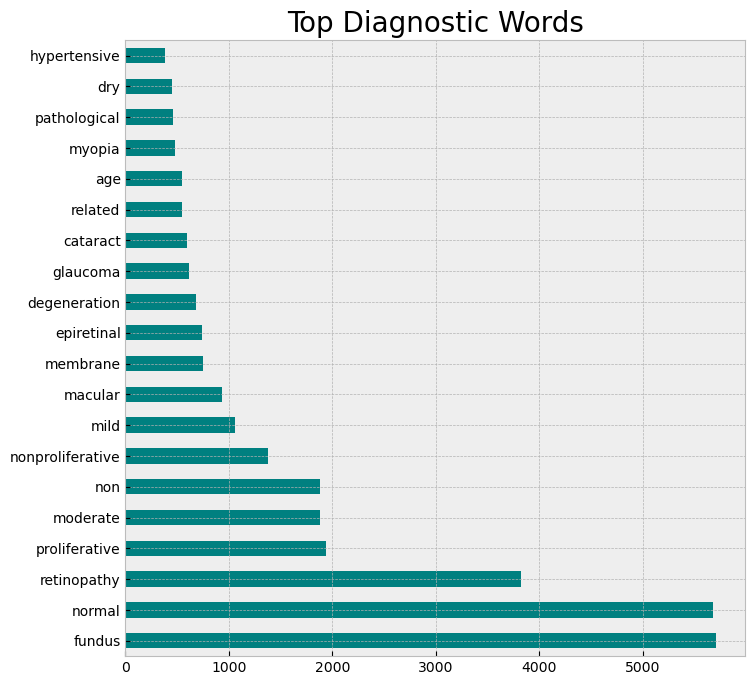

In [52]:
# combining words for right and left eyes
images['diagnostic_keywords'] = images['Left-Diagnostic Keywords'] + ' ' + images['Right-Diagnostic Keywords']

# countvectorizing all diagnostic keywords
words = images['diagnostic_keywords']
cv = CountVectorizer()
words_enc = cv.fit_transform(words)

# convert to dataframe
words_df = pd.DataFrame(words_enc.todense(), columns = cv.get_feature_names_out())

# see top words
words_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', color = 'teal', figsize = (8, 8))
plt.title('Top Diagnostic Words', size = 20);

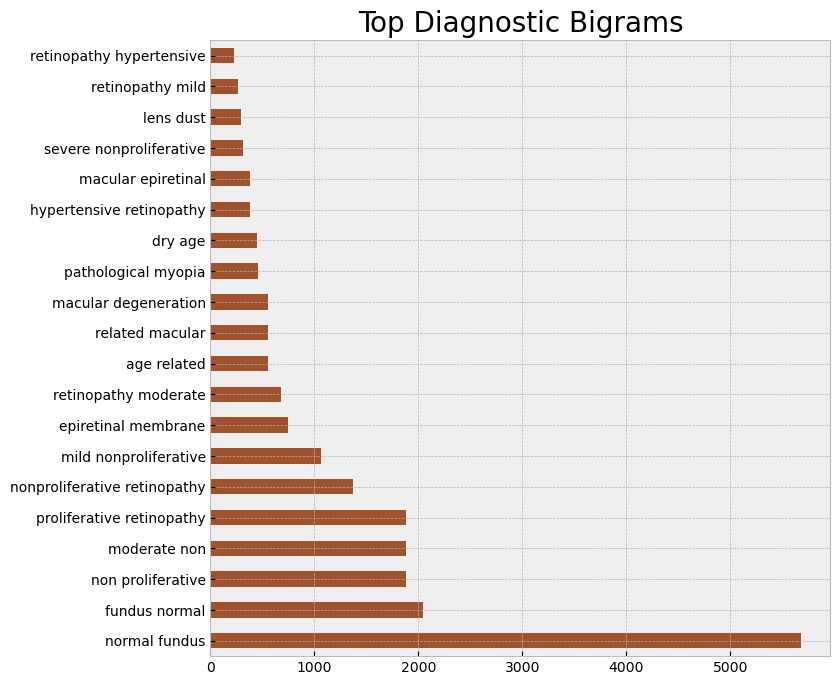

In [53]:
# seeing top bigrams
cv2 = CountVectorizer(ngram_range=(2, 2))
words_enc_bigram = cv2.fit_transform(words)
words_df_bigram = pd.DataFrame(words_enc_bigram.todense(), columns = cv2.get_feature_names_out())
words_df_bigram.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', color = 'sienna', figsize = (8, 8))
plt.title('Top Diagnostic Bigrams', size = 20);

In [9]:
dust_occurs = words_df_bigram['lens dust'].sum()

print(f'There are {dust_occurs} images where the medical professional reported lens dust. This is {round((dust_occurs/images.shape[0])*100, 2)}% of all images.')

There are 289 images where the medical professional reported lens dust. This is 4.52% of all images.


The biggest take away here is the amount of images that had enough lens dust for the reviewing medical professional to note the dust in their diagnosis. This may play a factor in a model learning from these images. This is a real life problem as these fundus imaging machines need routine maintenance to provide useful information.

In [10]:
left_unique_count = images['Left-Diagnostic Keywords'].nunique()
right_unique_count = images['Right-Diagnostic Keywords'].nunique()

print(f'There are {right_unique_count} unique diagnoses for the right eye and {left_unique_count} unique diagnoses for the left eye.')

There are 205 unique diagnoses for the right eye and 196 unique diagnoses for the left eye.


In [67]:
# see unique diagnoses
diagnoses_left = [diag for diag in images['Left-Diagnostic Keywords'].unique()]
diagnoses_right = [diag for diag in images['Right-Diagnostic Keywords'].unique()]
set(diagnoses_left + diagnoses_right)

{'abnormal pigment ',
 'anterior segment image',
 'atrophic change',
 'atrophy',
 'branch retinal artery occlusion',
 'branch retinal vein occlusion',
 'branch retinal vein occlusion，lens dust',
 'cataract',
 'cataract，branch retinal vein occlusion',
 'cataract，laser spot',
 'cataract，laser spot，moderate non proliferative retinopathy',
 'cataract，lens dust',
 'cataract，mild nonproliferative retinopathy',
 'cataract，moderate non proliferative retinopathy',
 'cataract，myelinated nerve fibers，moderate non proliferative retinopathy',
 'cataract，suspected cataract',
 'cataract，suspected glaucoma',
 'cataract，vitreous degeneration',
 'central retinal artery occlusion',
 'central retinal vein occlusion',
 'central serous chorioretinopathy',
 'chorioretinal atrophy',
 'chorioretinal atrophy with pigmentation proliferation',
 'chorioretinal atrophy with pigmentation proliferation，epiretinal membrane',
 'chorioretinal atrophy with pigmentation proliferation，lens dust',
 'chorioretinal atrophy，ep

In [170]:
low_quality = images[(images['Left-Diagnostic Keywords'] == 'low image quality') | (images['Right-Diagnostic Keywords'] == 'low image quality')]
print(f'{len(low_quality)} images labeled as low quality with no diagnosis.')
low_quality

18 images labeled as low quality with no diagnosis.


ID  Patient Age Patient Sex    Left-Fundus    Right-Fundus  \
2547  3935           45        Male  3935_left.jpg  3935_right.jpg   
2606  4007           71        Male  4007_left.jpg  4007_right.jpg   
2744  4169           48        Male  4169_left.jpg  4169_right.jpg   
2854  4290           51        Male  4290_left.jpg  4290_right.jpg   
2989  4442           62      Female  4442_left.jpg  4442_right.jpg   
2994  4448           50        Male  4448_left.jpg  4448_right.jpg   
3053  4522           67        Male  4522_left.jpg  4522_right.jpg   
3517   372           52      Female   372_left.jpg   372_right.jpg   
5748  3947           62        Male  3947_left.jpg  3947_right.jpg   
5848  4066           80      Female  4066_left.jpg  4066_right.jpg   
5901  4124           43        Male  4124_left.jpg  4124_right.jpg   
5947  4180           63        Male  4180_left.jpg  4180_right.jpg   
5963  4198           58      Female  4198_left.jpg  4198_right.jpg   
6025  4262           60        Male  4262_left.jpg  4262_right.jpg   
6080  4319           69        Male  4319_left.jpg  4319_right.jpg   
6146  4394           56        Male  4394_left.jpg  4394_right.jpg   
6176  4427           43        Male  4427_left.jpg  4427_right.jpg   
6321  4601           36        Male  4601_left.jpg  4601_right.jpg   

                    Left-Diagnostic Keywords  \
2547                       low image quality   
2606                       low image quality   
2744                       low image quality   
2854                       low image quality   
2989                       low image quality   
2994                       low image quality   
3053                       low image quality   
3517           low image quality,maculopathy   
5748  moderate non proliferative retinopathy   
5848  moderate non proliferative retinopathy   
5901  moderate non proliferative retinopathy   
5947  moderate non proliferative retinopathy   
5963  moderate non proliferative retinopathy   
6025       mild nonproliferative retinopathy   
6080  moderate non proliferative retinopathy   
6146       mild nonproliferative retinopathy   
6176       mild nonproliferative retinopathy   
6321  moderate non proliferative retinopathy   

                   Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
2547       mild nonproliferative retinopathy  0  1  0  0  0  0  0  0   
2606       mild nonproliferative retinopathy  0  1  0  0  0  0  0  0   
2744  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0   
2854                           normal fundus  1  0  0  0  0  0  0  0   
2989  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0   
2994  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0   
3053     severe nonproliferative retinopathy  0  1  0  0  0  0  0  0   
3517                       low image quality  0  0  0  0  0  0  0  1   
5748                       low image quality  0  1  0  0  0  0  0  0   
5848                       low image quality  0  1  0  0  0  0  0  0   
5901                       low image quality  0  1  0  0  0  0  0  0   
5947                       low image quality  0  1  0  0  0  0  0  0   
5963                       low image quality  0  1  0  0  0  0  0  0   
6025                       low image quality  0  1  0  0  0  0  0  0   
6080                       low image quality  0  1  0  0  0  0  0  0   
6146                       low image quality  0  1  0  0  0  0  0  0   
6176                       low image quality  0  1  0  0  0  0  0  0   
6321                       low image quality  0  1  0  0  0  0  0  0   

                                        filepath labels  \
2547  ../data/preprocessed_images/3935_right.jpg  ['D']   
2606  ../data/preprocessed_images/4007_right.jpg  ['D']   
2744  ../data/preprocessed_images/4169_right.jpg  ['D']   
2854  ../data/preprocessed_images/4290_right.jpg  ['N']   
2989  ../data/preprocessed_images/4442_right.jpg  ['D']   
2994  ../data/preprocessed_images/4448_ri

There is a large variety of specific diagnoses, a patient can have diabetic retinopathy but there are multiple levels of severity and location where it can occur. This, along with the less common conditions that are labeled as other, will account for how many unique written diagnoses there are compared to there only being eight general classes present. The low image quality images have already been removed from the preprocessed image dataset, but that's 18 fewer images to work with due to either technician or patient error during image taking.

Next I will look at how patient demographics are distributed for each disease class.

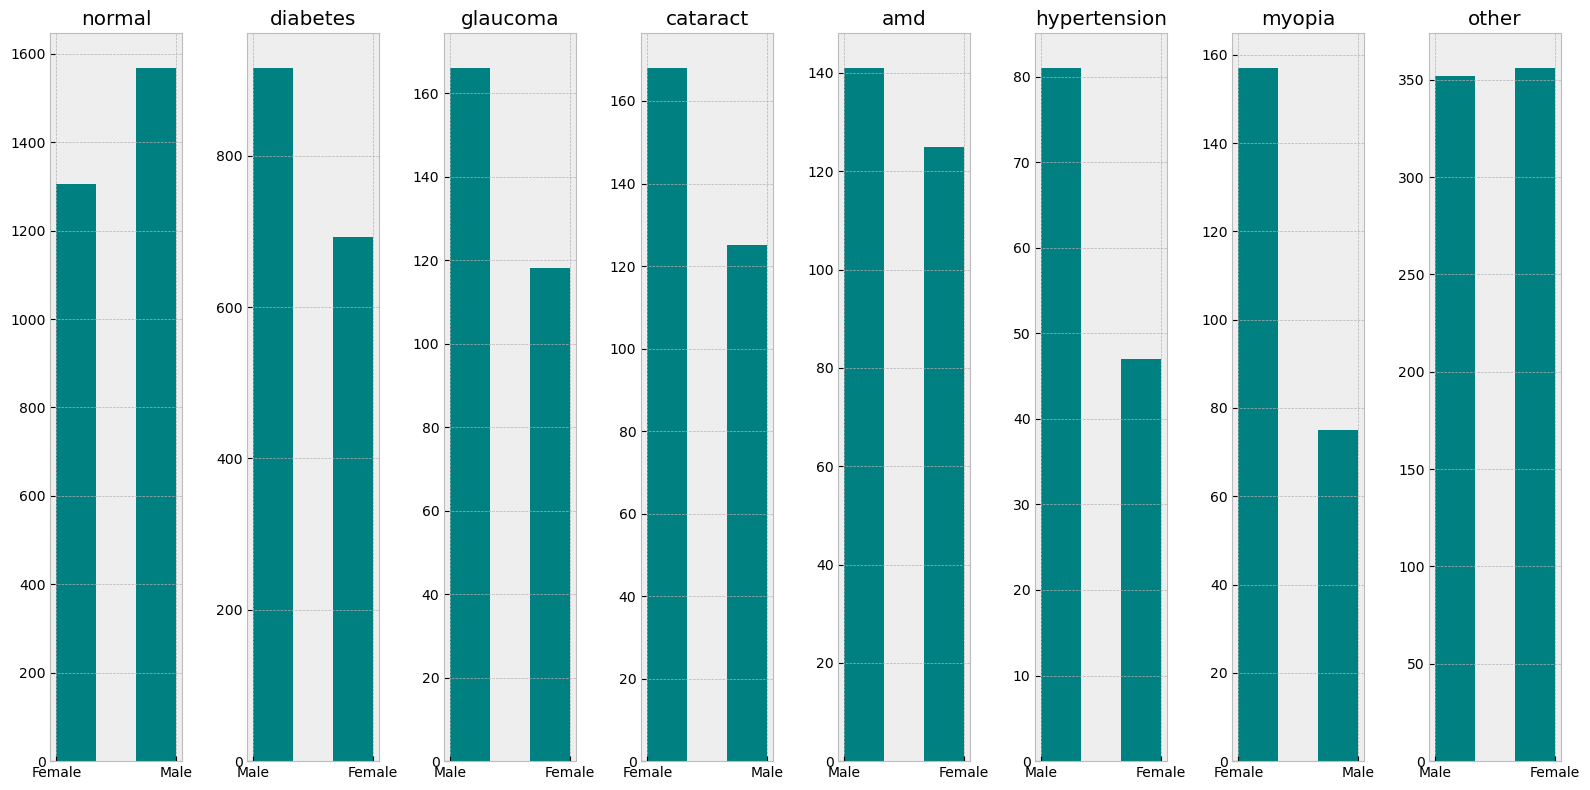

In [177]:
fig, ax = plt.subplots(1, 8, figsize = (16, 8))

for i, (disease, disease_class) in enumerate(disease_classes.items()):
    ax[i].hist(disease_class['Patient Sex'], bins = 3, color = 'teal')
    ax[i].set_title(disease)
plt.tight_layout();

There are more instances of some classes than other, but there are a significantly larger percentage of male patients with hypertension and female patients with pathological myopia compared to the other disease categories where the distribution is more even.

In [23]:
images.groupby(['labels', 'Patient Sex'])['Patient Age'].describe().T

labels            ['A']                   ['C']                   ['D']  \
Patient Sex      Female        Male      Female        Male      Female   
count        125.000000  141.000000  168.000000  125.000000  692.000000   
mean          60.624000   61.730496   67.273810   66.080000   56.716763   
std           12.646984   10.492092   10.806243   13.172307   10.260182   
min            1.000000   32.000000   36.000000   24.000000   18.000000   
25%           55.000000   56.000000   60.750000   57.000000   50.000000   
50%           62.000000   63.000000   69.000000   69.000000   58.000000   
75%           67.000000   67.000000   75.250000   75.000000   64.000000   
max           84.000000   87.000000   87.000000   91.000000   80.000000   

labels                        ['G']                  ['H']            \
Patient Sex        Male      Female        Male     Female      Male   
count        916.000000  118.000000  166.000000  47.000000  81.00000   
mean          54.931223   65.355932   61.361446  60.872340  54.82716   
std           10.093371    9.371283   11.666142   6.059908   7.42090   
min           17.000000   31.000000   24.000000  45.000000  37.00000   
25%           48.000000   59.000000   54.000000  58.000000  49.00000   
50%           55.000000   66.500000   62.000000  61.000000  55.00000   
75%           62.000000   71.000000   70.000000  65.000000  61.00000   
max           85.000000   84.000000   84.000000  70.000000  68.00000   

labels            ['M']                   ['N']                    ['O']  \
Patient Sex      Female       Male       Female         Male      Female   
count        157.000000  75.000000  1305.000000  1568.000000  356.000000   
mean          52.388535  60.120000    58.553257    56.040179   61.379213   
std           23.985212  11.423021    11.266860    11.118279    9.906579   
min            1.000000  29.000000     1.000000    15.000000   26.000000   
25%           49.000000  52.500000    52.000000    49.000000   56.000000   
50%           60.000000  61.000000    60.000000    56.000000   62.500000   
75%           67.000000  69.500000    66.000000    64.000000   68.000000   
max           79.000000  87.000000    89.000000    91.000000   82.000000   

labels                   
Patient Sex        Male  
count        352.000000  
mean          57.815341  
std           11.218752  
min           23.000000  
25%           52.000000  
50%           59.000000  
75%           65.000000  
max           89.000000

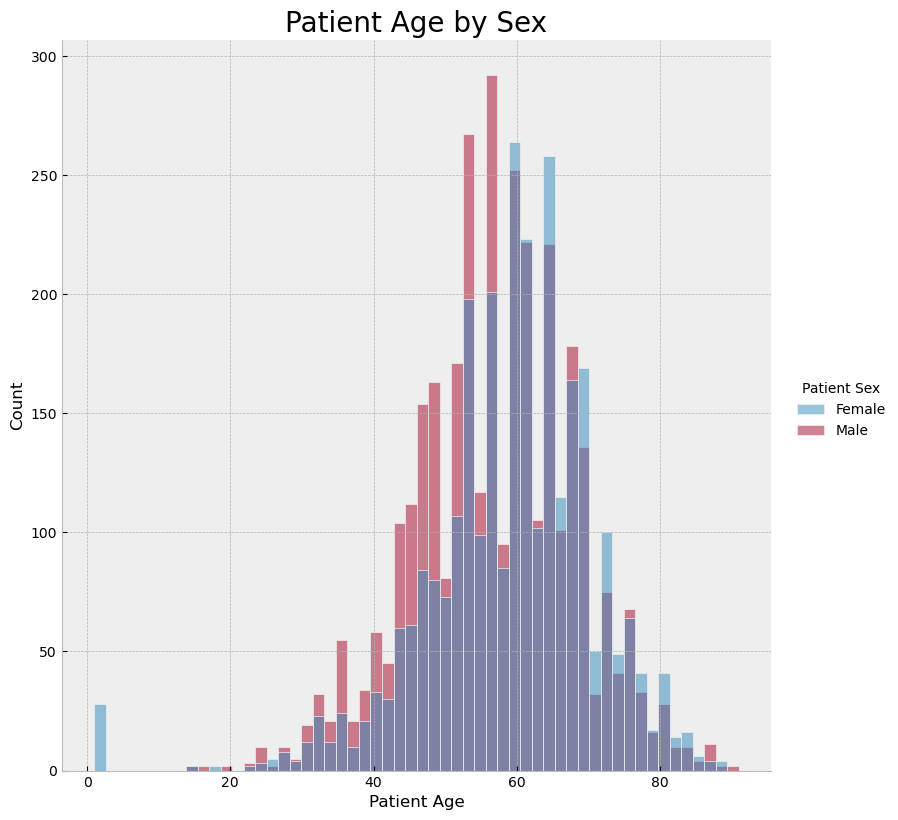

In [33]:
sns.displot(images, x = 'Patient Age', hue = 'Patient Sex', height = 8, aspect = 1)
plt.title('Patient Age by Sex', size = 20);

There are a few very young patients, but the majority are between the ages of 40 and 80. Also, there are more male patients represented under the age of 60 and more women over 60.

In [86]:
# see the young age outliers
one_year_olds = images[images['Patient Age'] == 1]
one_year_olds

ID  Patient Age Patient Sex    Left-Fundus    Right-Fundus  \
1013  1242            1      Female  1242_left.jpg  1242_right.jpg   
1218  1563            1      Female  1563_left.jpg  1563_right.jpg   
1219  1564            1      Female  1564_left.jpg  1564_right.jpg   
1220  1565            1      Female  1565_left.jpg  1565_right.jpg   
1222  1568            1      Female  1568_left.jpg  1568_right.jpg   
1233  1583            1      Female  1583_left.jpg  1583_right.jpg   
1237  1588            1      Female  1588_left.jpg  1588_right.jpg   
1238  1589            1      Female  1589_left.jpg  1589_right.jpg   
1239  1590            1      Female  1590_left.jpg  1590_right.jpg   
1242  1595            1      Female  1595_left.jpg  1595_right.jpg   
1244  1599            1      Female  1599_left.jpg  1599_right.jpg   
1245  1600            1      Female  1600_left.jpg  1600_right.jpg   
1248  1603            1      Female  1603_left.jpg  1603_right.jpg   
1260  1617            1      Female  1617_left.jpg  1617_right.jpg   
1293  1829            1      Female  1829_left.jpg  1829_right.jpg   
4412  1563            1      Female  1563_left.jpg  1563_right.jpg   
4413  1564            1      Female  1564_left.jpg  1564_right.jpg   
4414  1565            1      Female  1565_left.jpg  1565_right.jpg   
4416  1568            1      Female  1568_left.jpg  1568_right.jpg   
4425  1583            1      Female  1583_left.jpg  1583_right.jpg   
4428  1588            1      Female  1588_left.jpg  1588_right.jpg   
4429  1589            1      Female  1589_left.jpg  1589_right.jpg   
4430  1590            1      Female  1590_left.jpg  1590_right.jpg   
4435  1599            1      Female  1599_left.jpg  1599_right.jpg   
4436  1600            1      Female  1600_left.jpg  1600_right.jpg   
4439  1603            1      Female  1603_left.jpg  1603_right.jpg   
4450  1617            1      Female  1617_left.jpg  1617_right.jpg   
4481  1829            1      Female  1829_left.jpg  1829_right.jpg   

                      Left-Diagnostic Keywords  \
1013                     chorioretinal atrophy   
1218                       pathological myopia   
1219                       pathological myopia   
1220                       pathological myopia   
1222                       pathological myopia   
1233                       pathological myopia   
1237                       pathological myopia   
1238                       pathological myopia   
1239                             normal fundus   
1242  tessellated fundus，peripapillary atrophy   
1244                       pathological myopia   
1245                       pathological myopia   
1248                       pathological myopia   
1260                       pathological myopia   
1293      dry age-related macular degeneration   
4412                       pathological myopia   
4413                       pathological myopia   
4414                       pathological myopia   
4416                       pathological myopia   
4425                       pathological myopia   
4428                       pathological myopia   
4429                       pathological myopia   
4430                             normal fundus   
4435                       pathological myopia   
4436                       pathological myopia   
4439                       pathological myopia   
4450                       pathological myopia   
4481      dry age-related macular degeneration   

                 Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
1013                         normal fundus  0  0  0  0  0  0  0  1   
1218                   pathological myopia  0  0  0  0  0  0  1  0   
1219                   pathological myopia  0  0  0  0  0  0  1  0   
1220                   pathological myopia  0  0  0  0  0  0  1  0   
1222                   pathological myopia  0  0  0  0  0  0  1  0   
1233                   pathological myopia  0  0  0  0  0  0  1  0   
1237                   pathological 

In [178]:
no_1_year_olds = images[images['Patient Age'] != 1]
no_1_year_olds.groupby(['labels', 'Patient Sex'])['Patient Age'].describe().T

labels            ['A']                   ['C']                   ['D']  \
Patient Sex      Female        Male      Female        Male      Female   
count        123.000000  141.000000  168.000000  125.000000  692.000000   
mean          61.593496   61.730496   67.273810   66.080000   56.716763   
std           10.165707   10.492092   10.806243   13.172307   10.260182   
min           37.000000   32.000000   36.000000   24.000000   18.000000   
25%           55.000000   56.000000   60.750000   57.000000   50.000000   
50%           62.000000   63.000000   69.000000   69.000000   58.000000   
75%           67.000000   67.000000   75.250000   75.000000   64.000000   
max           84.000000   87.000000   87.000000   91.000000   80.000000   

labels                        ['G']                  ['H']            \
Patient Sex        Male      Female        Male     Female      Male   
count        916.000000  118.000000  166.000000  47.000000  81.00000   
mean          54.931223   65.355932   61.361446  60.872340  54.82716   
std           10.093371    9.371283   11.666142   6.059908   7.42090   
min           17.000000   31.000000   24.000000  45.000000  37.00000   
25%           48.000000   59.000000   54.000000  58.000000  49.00000   
50%           55.000000   66.500000   62.000000  61.000000  55.00000   
75%           62.000000   71.000000   70.000000  65.000000  61.00000   
max           85.000000   84.000000   84.000000  70.000000  68.00000   

labels            ['M']                   ['N']                    ['O']  \
Patient Sex      Female       Male       Female         Male      Female   
count        133.000000  75.000000  1303.000000  1568.000000  356.000000   
mean          61.661654  60.120000    58.641596    56.040179   61.379213   
std           10.635053  11.423021    11.047225    11.118279    9.906579   
min           30.000000  29.000000    14.000000    15.000000   26.000000   
25%           57.000000  52.500000    53.000000    49.000000   56.000000   
50%           62.000000  61.000000    60.000000    56.000000   62.500000   
75%           69.000000  69.500000    66.000000    64.000000   68.000000   
max           79.000000  87.000000    89.000000    91.000000   82.000000   

labels                   
Patient Sex        Male  
count        352.000000  
mean          57.815341  
std           11.218752  
min           23.000000  
25%           52.000000  
50%           59.000000  
75%           65.000000  
max           89.000000

The majority of one years olds in the dataset are shown to have pathological myopia, there are a few labeled with age related macular degeneration which doesn't make sense, so the age could be a data entry error. Looking at the statistics without the one year olds listed, the spread of age is much smaller for some diseases seen by the smaller standard deviations.

In [180]:
# find eyes with matching diagnoses
images['eye'] = images['filename'].map(lambda x: 'left' if 'left' in x else 'right')

unique_ids = images['ID'].unique()
disease_labels = images['labels'].unique()

one_eye = 0
both_same = 0
different = 0

for id in unique_ids:
    unique_patient = images[images['ID'] == id]
    if len(unique_patient) == 2:
        if unique_patient.iloc[0, -3] == unique_patient.iloc[1, -3]:
            both_same += 1
        else:
            different += 1
    else:
        one_eye += 1

print(f'Same diagnosis: {both_same}')
print(f'Different diagnoses: {different}')
print(f'Only one eye image: {one_eye}')
print(f'Percentage of patients with same diagnosis in both eyes: {round(both_same / (both_same + different)*100, 2)}')

Same diagnosis: 2146
Different diagnoses: 888
Only one eye image: 324
Percentage of patients with same diagnosis in both eyes: 70.73


Majority of patients have the same general diagnosis for both eyes, looking at specific conditions to see if some are more common in both eyes than others.

In [168]:
# function to count same condition occurances
def same_disease(df, label):
    '''
    Counts occurrences where both eyes of the same patient have the same condition versus when they have
    different conditions, and returns the counts along with the number of unique patients.

    Parameters:
    ----------
    df : pandas.DataFrame
        A dataframe containing 'ID' column that unique identifies patients
        and includes rows for each eye of the patient.

    Returns:
    -------
    tuple
        A tuple containing three values:
        - both_same (int): The count of patients where both eyes have the same condition.
        - different (int): The count of patients where both eyes have different conditions.
        - unique_patients (int): The total number of unique patients in the dataframe.
    '''
    both_same = 0
    different = 0

    for id in df['ID'].unique():
        unique_patient = df[df['ID'] == id]
        if len(unique_patient) == 2:
            both_same += 1
        else:
            different += 1
    return both_same, different, df['ID'].nunique()

In [166]:
print(f'Percentage of patients with no condition in either eye: {round((same_disease(normal)[0]/
                                                                        same_disease(normal)[2])*100, 2)}%')
print(f'Percentage of patients with Diabetes in both eyes: {round((same_disease(diabetes)[0]/
                                                                   same_disease(diabetes)[2])*100, 2)}%')
print(f'Percentage of patients with Glaucoma in both eyes: {round((same_disease(glaucoma)[0]/
                                                                   same_disease(glaucoma)[2])*100, 2)}%')
print(f'Percentage of patients with Cataracts in both eyes: {round((same_disease(cataract)[0]/
                                                                    same_disease(cataract)[2])*100, 2)}%')
print(f'Percentage of patients with Age Related Macular Degeneration in both eyes: {round((same_disease(amd)[0]/
                                                                                           same_disease(amd)[2])*100, 2)}%')
print(f'Percentage of patients with Hypertension in both eyes: {round((same_disease(hypertension)[0]/
                                                                       same_disease(hypertension)[2])*100, 2)}%')
print(f'Percentage of patients with Pathological Myopia in both eyes: {round((same_disease(myopia)[0]/
                                                                              same_disease(myopia)[2])*100, 2)}%')
print(f'Percentage of patients with some other condition in both eyes: {round((same_disease(other)[0]/
                                                                               same_disease(other)[2])*100, 2)}%')

Percentage of patients with no condition in either eye: 55.13%
Percentage of patients with Diabetes in both eyes: 56.57%
Percentage of patients with Glaucoma in both eyes: 56.04%
Percentage of patients with Cataracts in both eyes: 44.33%
Percentage of patients with Age Related Macular Degeneration in both eyes: 72.73%
Percentage of patients with Hypertension in both eyes: 70.67%
Percentage of patients with Pathological Myopia in both eyes: 50.65%
Percentage of patients with some other condition in both eyes: 18.2%


Age Related Macular Degeneration and Hypertension are the two conditions that most often affect both eyes, most patients with a condition that doesn't fall under the six listed only have it in one eye, and the rest of the patients are close to half and half for a condition affecting both eyes or only one.

Next I will look at how the different classes are represented across the entire dataset.

In [11]:
# value counts for the multiclass problem
images['labels'].value_counts(normalize = True)

labels
['N']    0.449468
['D']    0.251564
['O']    0.110763
['C']    0.045839
['G']    0.044431
['A']    0.041615
['M']    0.036295
['H']    0.020025
Name: proportion, dtype: float64

In [12]:
# value counts for the binary class problem
print(f'Normal: {round(normal.shape[0]/(normal.shape[0] + not_normal.shape[0]), 4)}')
print(f'Not Normal: {round(not_normal.shape[0]/(normal.shape[0] + not_normal.shape[0]), 4)}')

Normal: 0.4495
Not Normal: 0.5505


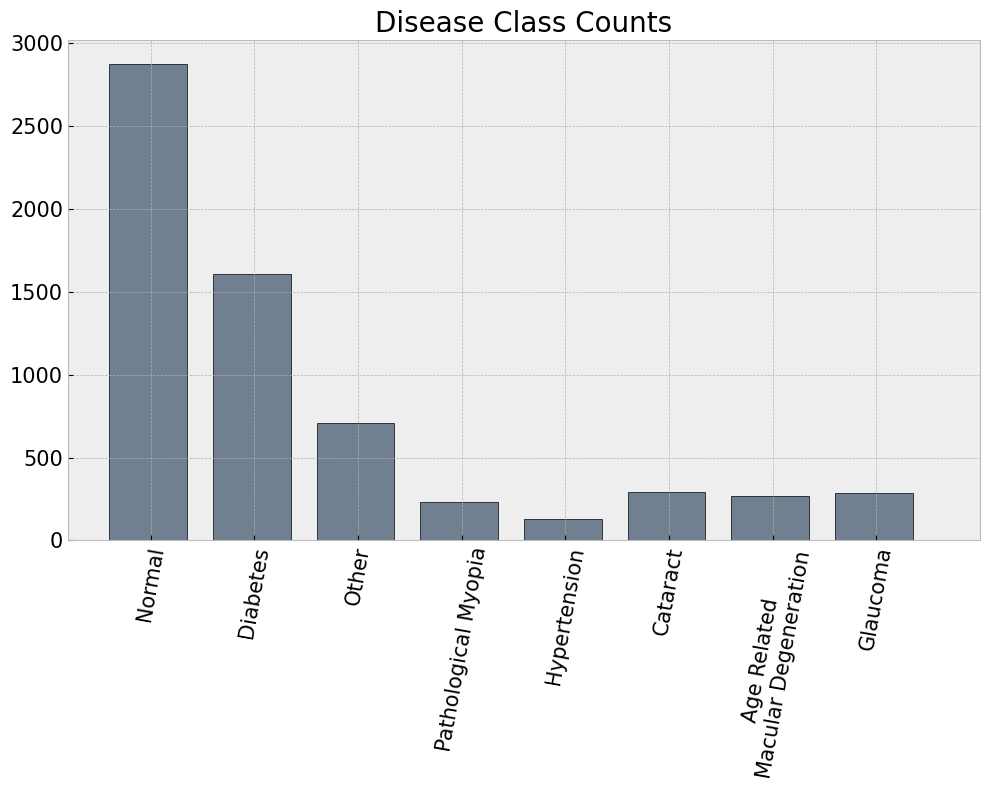

In [13]:
# visualize imbalance of multiple classes
# method for bins to center over xticks found on stack overflow
# https://stackoverflow.com/questions/27083051/matplotlib-xticks-not-lining-up-with-histogram
plt.figure(figsize = (10, 8))
plt.hist(images['labels'], bins = np.arange(9)-0.4, width = 0.75, edgecolor = 'black', color = 'slategrey')
plt.title('Disease Class Counts', size = 20)
plt.xticks(ticks = range(8), labels = ['Normal', 'Diabetes', 'Other', 'Pathological Myopia', 'Hypertension',
                                       'Cataract', 'Age Related\nMacular Degeneration', 'Glaucoma'], rotation = 80, fontsize = '15')
plt.yticks(fontsize = 15)
# saving image for presentation slides
plt.tight_layout()
plt.savefig('../images/multiclass_histogram.png');

The binary classes of normal vs not normal fundus photos are relatively balanced, but the multiclasses are very imbalanced. Further, the third highest occuring class is 'Other' so the images might not all have much in common if there are many less common disesaI expect the binary class model to outperform the multiclass model I'll be pursuing.

To get a better feel for the data, I'll display a few images for each disease class.

In [33]:
# resetting indeces of series for each class
for disease in disease_classes.values():
    disease.reset_index(drop = True, inplace = True)

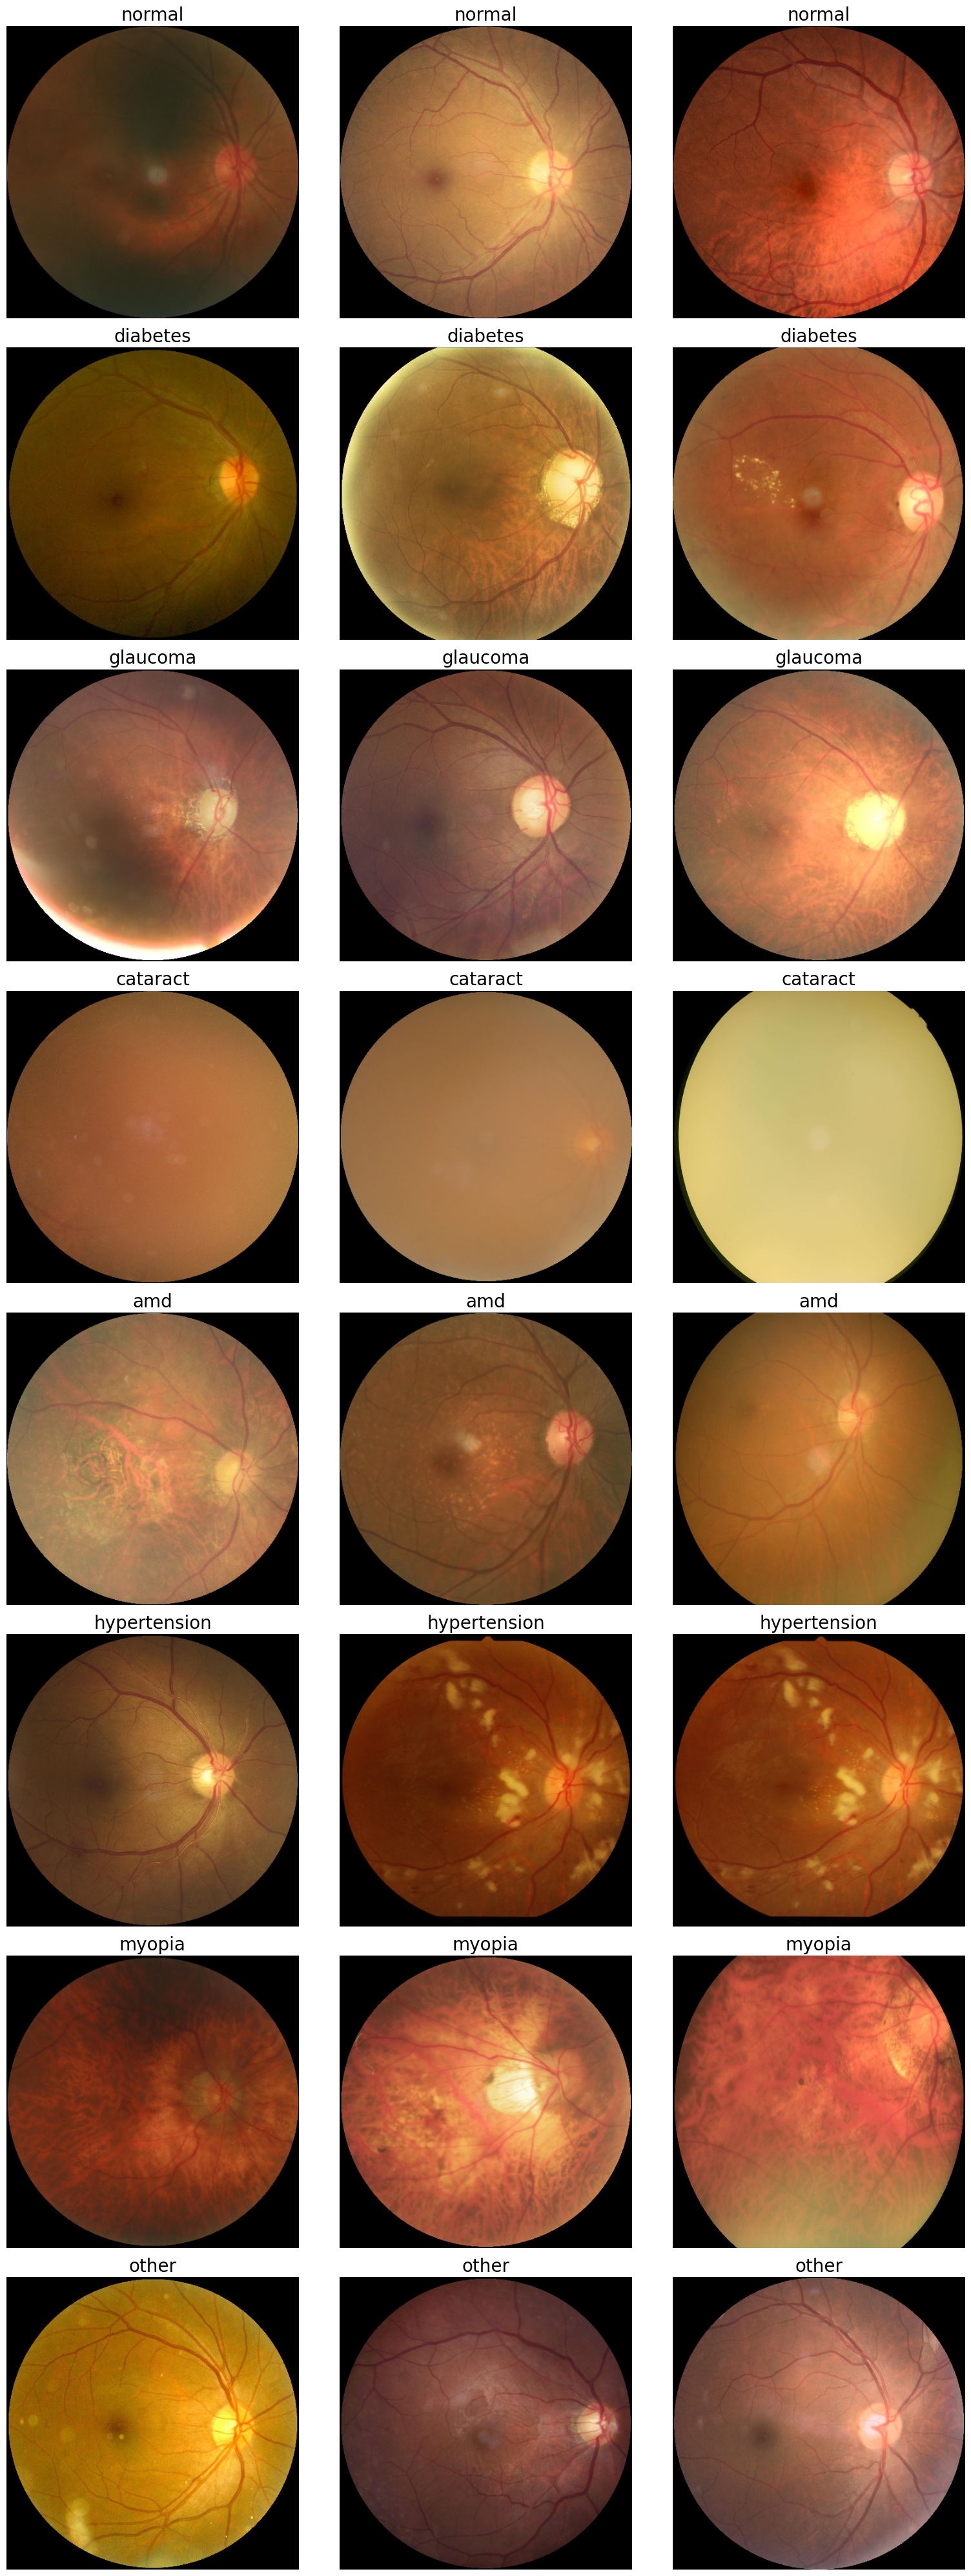

In [35]:
# initiate subplots to display images
fig, ax = plt.subplots(8, 3, figsize = (16, 40))

# iterate through each disease directory
for i, (disease, disease_df) in enumerate(disease_classes.items()):
    # iterate through first three images of each directory
    for j, disease_image in enumerate(disease_df.loc[:2, 'filepath']):
        # read in images
        with Image.open(disease_image) as image:
    
            # display images in subplots
            ax[i, j].imshow(image)
            ax[i, j].set_title(disease, size = 20)
            ax[i, j].set_axis_off()
            
plt.tight_layout();

To the untrained eye, it's hard to categorize each of the above images under their correct condition. From my previous experience working in an optometry practice I think a machine learning model will do a better job categorizing some conditions more than others, this is because certain conditions occur in different areas of the retina(eg. macular degeneration occurs in the macula, glaucoma shows up in the optic nerve, etc.), while other can happen in several different parts of the retina. 

## Image Augmentation

Since any condition can affect either eye with no discrimination, I'm going to flip all images horizontally to mimic the opposite eye.

There is code below that is commented out because I considered other augmentation options:
* Converting images to grayscale to try and mimic a common fundus photography machine setting called autofluorescense.
* Creating flipped and grayscale images.
* Getting cropped views of the macula and optic nerve to highlight these areas as they are common areas for certain conditions to appear.

I ended up removing these augmentations. This is in part due to the increased dataset size causing models to train very slowly, and also I wasn't seeing improvement in model performance. I will add some randomized augmentation during model fitting in the next notebook.

First I'm going to verify the preprocessed images are all the same size.

In [16]:
# compare image sizes
image_sizes = []
for i in range(images.shape[0]):
    with Image.open(images.loc[i, 'filepath']) as image:
        image_sizes.append(image.size)

print(f'Out of {len(image_sizes)} images, there is {len(set(image_sizes))} unique size of {set(image_sizes)}')

Out of 6392 images, there is 1 unique size of {(512, 512)}


In [17]:
# function to create grayscale image
# followed examples on geeks for geeks
# https://www.geeksforgeeks.org/python-pil-image-convert-method/
def color_to_grayscale(origin_path, destination_path):
    '''
    Convert a color image to grayscale and save the resulting image.

    This function takes the path of an original color image, converts it to grayscale,
    and saves the new grayscale image to the specified destination

    Parameters:
    ----------
    origin_path: str
        The file path of the original color image to be converted.
    destination_path: str
        The file path where the grayscale image will be saved.

    Returns:
    -------
    None
    '''
    # open original image
    with Image.open(origin_path) as original_image:
        
        # convert to gray scale
        grayscale_image = original_image.convert('L')
    
        # save converted image
        grayscale_image.save(destination_path)

In [15]:
# function to flip image
# followed example on geeks for geeks
# https://www.geeksforgeeks.org/how-to-flip-an-image-horizontally-or-vertically-in-python/
def flip_image(origin_path, destination_path):
    '''
    Flip an image horizontally and save the resulting image.

    This function takes the path of an original image, flips it on the horizontal axis,
    and saves the new image to the specified destination

    Parameters:
    ----------
    origin_path: str
        The file path of the original image to be transposed.
    destination_path: str
        The file path where the flipped image will be saved.

    Returns:
    -------
    None
    '''
    # open original image
    with Image.open(origin_path) as original_image:
    
        # flip image horizontally
        flipped_image = original_image.transpose(Image.FLIP_LEFT_RIGHT)
    
        # save flipped image
        flipped_image.save(destination_path)

In [19]:
# function to get flipped and grayscale image
def flip_to_gray(origin_path, destination_path):
    '''
    Convert a color image to grayscale, flips the image horizontally, and save the resulting image.

    This function takes the path of an original color image, flips it on the horizontal axis, converts it to grayscale,
    and saves the new image to the specified destination

    Parameters:
    ----------
    origin_path: str
        The file path of the original color image to be converted.
    destination_path: str
        The file path where the flipped grayscale image will be saved.

    Returns:
    -------
    None
    '''
    # open original image
    with Image.open(origin_path) as original_image:
        
        # flip image horizontally
        flipped_image = original_image.transpose(Image.FLIP_LEFT_RIGHT)
        # convert flipped image to grayscale
        flipped_gray = flipped_image.convert('L')

        # save flipped grayscale image
        flipped_gray.save(destination_path)

In [20]:
# # create grayscale images for each disease in the multiclass problem
# for disease, disease_df in disease_classes.items():
#     disease_df['filename'].map(lambda x: color_to_grayscale('../data/preprocessed_images/'+x,
#                                                             '../data/multiclass/'+disease+'/'+x.replace('.jpg', '_gray.jpg')))

In [21]:
# create flipped images for each disease in multiclass problem
for disease, disease_df in disease_classes.items():
    disease_df['filename'].map(lambda x: flip_image('../data/preprocessed_images/'+x,
                                                    '../data/multiclass/'+disease+'/'+x.replace('.jpg', '_flip.jpg')))

# # also create flipped grayscale images
# for disease, disease_df in disease_classes.items():
#     disease_df['filename'].map(lambda x: flip_to_gray('../data/preprocessed_images/'+x,
#                                                       '../data/multiclass/'+disease+'/'+x.replace('.jpg', '_flip_gray.jpg')))

In [16]:
# creating grayscale, flipped, and flipped grayscale images for binary class directories
# normal['filename'].map(lambda x: color_to_grayscale('../data/preprocessed_images/'+x,
#                                                     '../data/binary/0/'+x.replace('.jpg', '_gray.jpg')))
normal['filename'].map(lambda x: flip_image('../data/preprocessed_images/'+x,
                                            '../data/binary/0/'+x.replace('.jpg', '_flip.jpg')))
# normal['filename'].map(lambda x: flip_to_gray('../data/preprocessed_images/'+x,
#                                               '../data/binary/0/'+x.replace('.jpg', '_flip_gray.jpg')))

# not_normal['filename'].map(lambda x: color_to_grayscale('../data/preprocessed_images/'+x,
#                                                         '../data/binary/1/'+x.replace('.jpg', '_gray.jpg')))
not_normal['filename'].map(lambda x: flip_image('../data/preprocessed_images/'+x,
                                                '../data/binary/1/'+x.replace('.jpg', '_flip.jpg')))
# not_normal['filename'].map(lambda x: flip_to_gray('../data/preprocessed_images/'+x,
#                                                   '../data/binary/1/'+x.replace('.jpg', '_flip_gray.jpg')))

2       None
3       None
4       None
5       None
6       None
        ... 
6387    None
6388    None
6389    None
6390    None
6391    None
Name: filename, Length: 3519, dtype: object

In [24]:
# functions to created cropped images of macula and optic nerve
def crop_macula(origin_path, destination_path):
    '''
    Crop the macula region from a retinal photo image and save the cropped image.

    This function checks for which eye the image is extracts a specific region of interest (macula) from the input image.
    It checks whether the image corresonds to the right or left eye and adjusts the crop coordinates accordingly.
    The cropped region is then resized to a standardized size (512x512), and saved to the specified destination.    

    Parameters:
    ----------
    origin_path: str
        The file path of the original image to be converted.
        The file name should include 'right' or 'left' to indicate the eye.
    destination_path: str
        The file path where the cropped and resized image will be saved.

    Returns:
    -------
    None
    '''
    # open original image
    with Image.open(origin_path) as original_image:

        # check for which eye
        if 'right' in origin_path:
            # get cropped view of macula
            macula = original_image.crop([50, 150, 300, 400])
        else:
            macula = original_image.crop([187, 150, 462, 400])

        # resize to keep images all the same size
        macula_resized = macula.resize((512, 512))

        # save cropped image
        macula_resized.save(destination_path)


def crop_optic_nerve(origin_path, destination_path):
    '''
    Crop the optic nerve region from a retinal photo image and save the cropped image.

    This function checks for which eye the image is extracts a specific region of interest (optic nerve) from the input image.
    It checks whether the image corresonds to the right or left eye and adjusts the crop coordinates accordingly.
    The cropped region is then resized to a standardized size (512x512), and saved to the specified destination.
    

    Parameters:
    ----------
    origin_path: str
        The file path of the original image to be converted.
        The file name should include 'right' or 'left' to indicate the eye.
    destination_path: str
        The file path where the cropped and resized image will be saved.

    Returns:
    -------
    None
    '''
    # open original image
    with Image.open(origin_path) as original_image:

        # check for which eye
        if 'right' in origin_path:
            # get cropped view of optic nerve
            optic_nerve = original_image.crop([200, 115, 475, 390])
        else:
            optic_nerve = original_image.crop([37, 115, 312, 390])

        # resize to keep images all the same size
        optic_nerve_resized = optic_nerve.resize((512, 512))

        # save cropped image
        optic_nerve_resized.save(destination_path)

In [25]:
# # extract macula and optic nerve cropped images for all diseases
# for disease, disease_df in disease_classes.items():
#     disease_df['filename'].map(lambda x: crop_macula('../data/preprocessed_images/'+x,
#                                                      '../data/multiclass/'+disease+'/'+x.replace('.jpg', '_mac.jpg')))
# for disease, disease_df in disease_classes.items():
#     disease_df['filename'].map(lambda x: crop_optic_nerve('../data/preprocessed_images/'+x,
#                                                           '../data/multiclass/'+disease+'/'+x.replace('.jpg', '_nerve.jpg')))

# # extract macula and optic nerve for binary classes
# normal['filename'].map(lambda x: crop_macula('../data/preprocessed_images/'+x,
#                                              '../data/binary/0/'+x.replace('.jpg', '_mac.jpg')))
# normal['filename'].map(lambda x: crop_optic_nerve('../data/preprocessed_images/'+x,
#                                                   '../data/binary/0/'+x.replace('.jpg', '_nerve.jpg')))

# not_normal['filename'].map(lambda x: crop_macula('../data/preprocessed_images/'+x,
#                                                  '../data/binary/1/'+x.replace('.jpg', '_mac.jpg')))
# not_normal['filename'].map(lambda x: crop_optic_nerve('../data/preprocessed_images/'+x,
#                                                       '../data/binary/1/'+x.replace('.jpg', '_nerve.jpg')))

2       None
3       None
4       None
5       None
6       None
        ... 
6387    None
6388    None
6389    None
6390    None
6391    None
Name: filename, Length: 3519, dtype: object